In [1]:
%load_ext autoreload
%autoreload 2

In [8]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from pandas import DataFrame, Series
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import RobustScaler

from datatools import extract_market_data, data_quantization
from pipeline import Dataset
from pipeline.backtest import evaluation_for_submission, cross_validation
from visualization.metric import plot_performance

import xarray as xr
import seaborn as sns
sns.set_theme(style="whitegrid")

In [3]:
from qids_lib import QIDS

dataset = Dataset.load('../../data/parsed')
qids = QIDS(path_prefix='../../')

In [4]:
from datatools import calculate_market_return

m_df = extract_market_data(dataset.market)
market_return = calculate_market_return(m_df)
full_df = pd.concat([dataset.fundamental, m_df, dataset.ref_return], axis=1).merge(market_return, left_on='day', right_index=True).dropna()

In [5]:
ds = xr.Dataset.from_dataframe(full_df)

## Some basic information about the dataset

In [7]:
ds

<xarray.Dataset>
Dimensions:            (day: 998, asset: 54)
Coordinates:
  * day                (day) int64 1 2 3 4 5 6 7 ... 992 993 994 995 996 997 998
  * asset              (asset) int64 0 1 2 3 4 5 6 7 ... 46 47 48 49 50 51 52 53
Data variables: (12/13)
    turnoverRatio      (day, asset) float64 3.679 2.515 1.286 ... 0.5684 1.293
    transactionAmount  (day, asset) float64 1.723e+04 3.706e+03 ... 9.681e+03
    pe_ttm             (day, asset) float64 34.44 28.99 42.94 ... 28.99 10.65
    pe                 (day, asset) float64 32.3 27.27 41.93 ... 28.99 10.65
    pb                 (day, asset) float64 4.942 5.055 4.808 ... 5.785 1.996
    ps                 (day, asset) float64 3.818 3.048 4.139 ... 3.715 0.4073
    ...                 ...
    avg_price          (day, asset) float64 24.55 16.17 9.059 ... 28.85 9.821
    volatility         (day, asset) float64 0.862 0.8046 ... 0.8039 0.5421
    mean_volume        (day, asset) float64 4.541e+05 1.769e+05 ... 2.528e+05
    return_0           (day, asset) float64 -0.02523 -0.0119 ... 0.01992
    return             (day, asset) float64 -0.02688 -0.05267 ... -0.003662
    market_return_0    (day, asset) float64 -0.006928 -0.006928 ... -0.007671

## Turnover

<AxesSubplot: xlabel='asset', ylabel='turnoverRatio'>

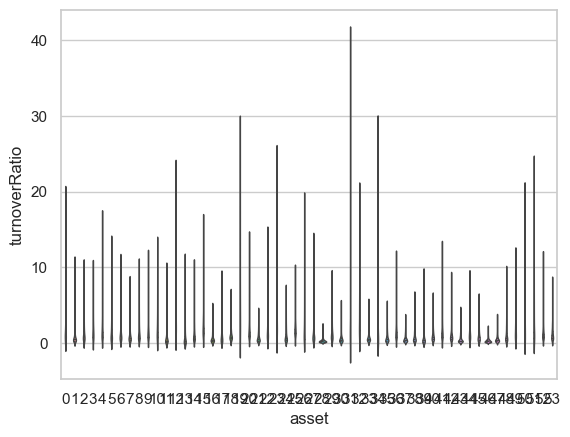

In [12]:
feature = 'turnoverRatio'
sns.violinplot(data=ds[feature].to_dataframe().reset_index(), x='asset', y=feature, inner='quart', linewidth=1)

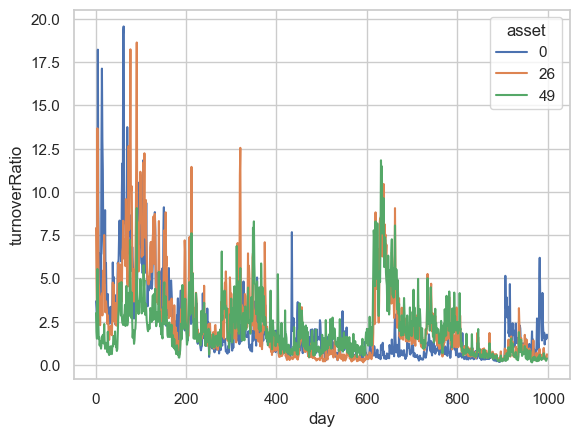

In [97]:
feature = 'turnoverRatio'
ds[feature].sel(asset=[0,26,49]).plot.line(x='day')

**For Turnover**
So apparently, the first 200 days display a quite different characteristic than the remaining days; the last 50 days is also worth noticing.

<AxesSubplot: xlabel='turnoverRatio', ylabel='return_0'>

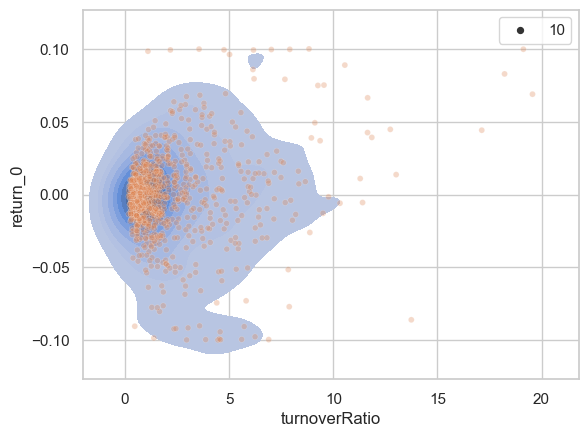

In [26]:
df = ds[['turnoverRatio', 'return_0']].sel(asset=0).to_dataframe()
plt.figure()
sns.kdeplot(data=df, x=feature, y='return_0', ax=plt.gca(), fill=True)
sns.scatterplot(data=df, x=feature, y='return_0', ax=plt.gca(), alpha=0.3, size=10)

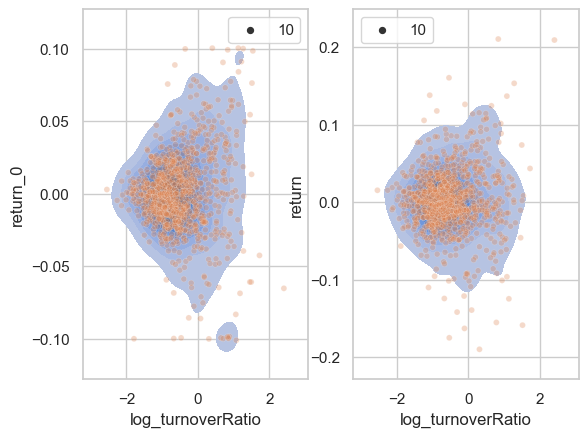

In [32]:
df = ds[['turnoverRatio', 'return_0', 'return']].sel(asset=1).to_dataframe()
df[f'log_{feature}'] = np.log(df[feature])
fig, axs = plt.subplots(nrows=1, ncols=2)
# return_label = 'return_0'
return_label = 'return'
for ax, return_label in zip(axs, ['return_0', 'return']):
    sns.kdeplot(data=df, x=f'log_{feature}', y=return_label, ax=ax, fill=True)
    sns.scatterplot(data=df, x=f'log_{feature}', y=return_label, ax=ax, alpha=0.3, size=10)

Question: Does the turnoverRatio correlate across different assets?

In [95]:
corr = ds.sel(day=slice(200,998))['turnoverRatio'].to_dataframe().reset_index().pivot(index='day', columns='asset', values='turnoverRatio').corr()
corr.index.rename('asset_0', inplace=True)
corr_long = corr.stack().rename('correlation')

Text(0.5, 1.0, 'Correlation plot for transactionAmount')

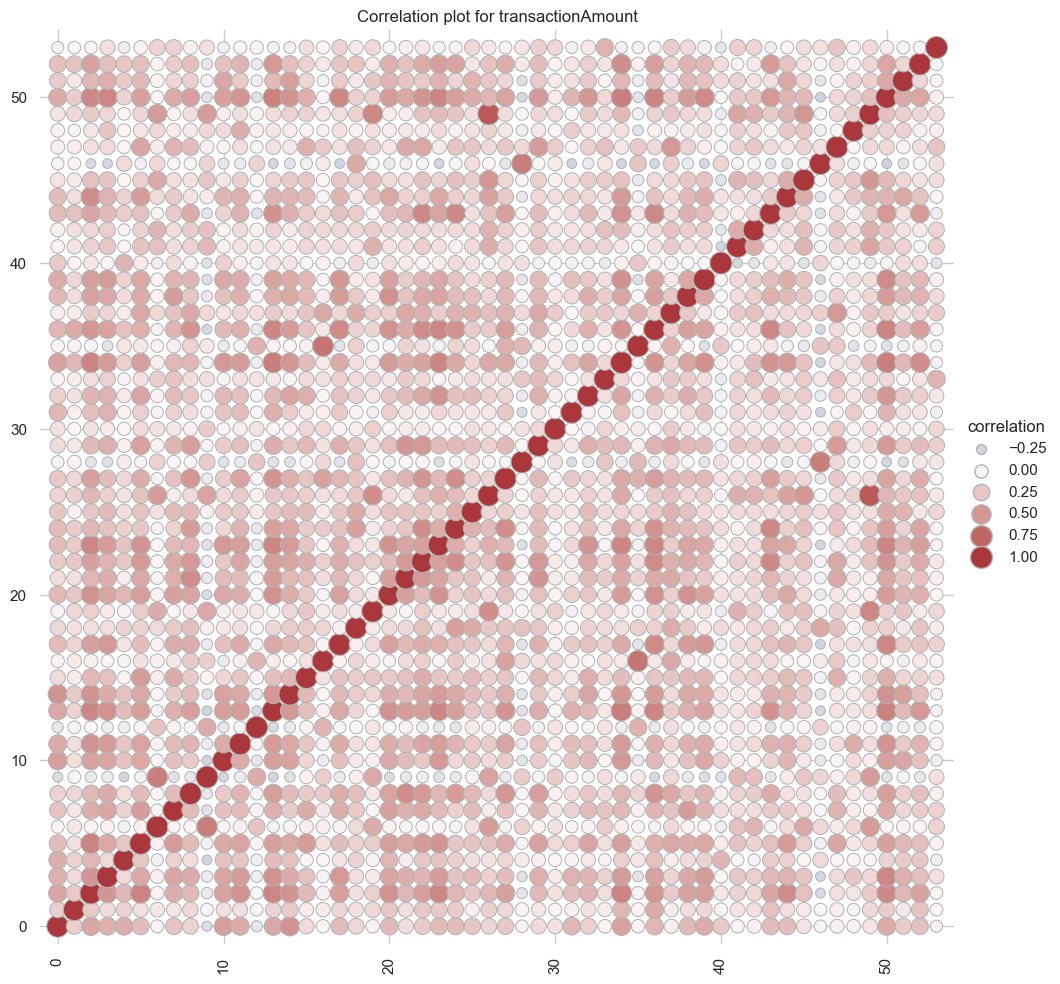

In [96]:
g = sns.relplot(
    data=corr_long.reset_index(),
    x='asset', y='asset_0', hue='correlation', size='correlation',
    palette="vlag", hue_norm=(-1, 1), edgecolor=".7",
    height=10, sizes=(50, 250), size_norm=(-.2, .8),
)

# Tweak the figure to finalize
g.set(xlabel="", ylabel="", aspect="equal")
g.despine(left=True, bottom=True)
g.ax.margins(.02)
for label in g.ax.get_xticklabels():
    label.set_rotation(90)
for artist in g.legend.legendHandles:
    artist.set_edgecolor(".7")
plt.title(f'Correlation plot for {feature}')

## TransactionAmount

<AxesSubplot: xlabel='asset', ylabel='transactionAmount'>

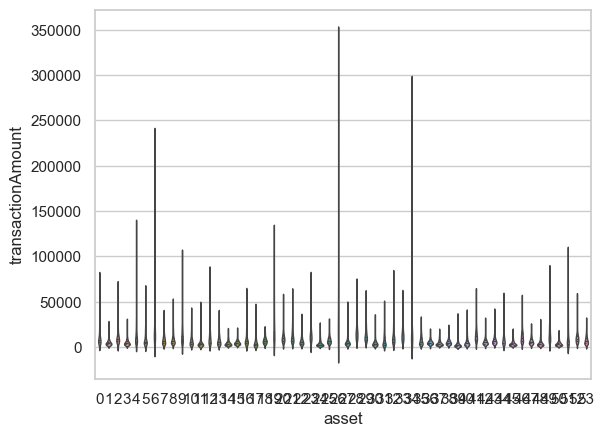

In [74]:
feature = 'transactionAmount'
sns.violinplot(data=ds[feature].to_dataframe().reset_index(), x='asset', y=feature, inner='quart', linewidth=1)

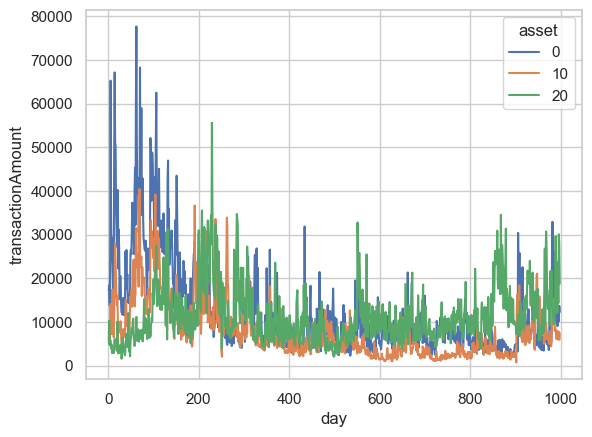

In [92]:
feature = 'transactionAmount'
ds[feature].sel(asset=[0,10,20]).plot.line(x='day')

Looks like TransactionAmount is very close to turnoverRatio, fishy

In [76]:
ratio = ds['transactionAmount'] / ds['turnoverRatio']

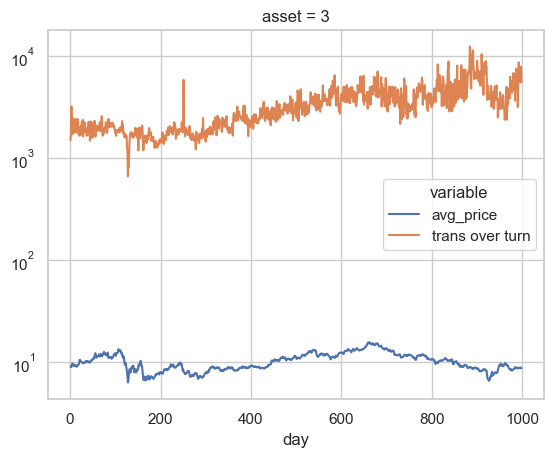

In [89]:
ds[['avg_price']].merge(ratio.rename('trans over turn')).sel(asset=3).to_array().plot.line(x='day')
plt.yscale('log')

Question: Does the transactionAmount correlate across different assets?

<Figure size 640x480 with 0 Axes>

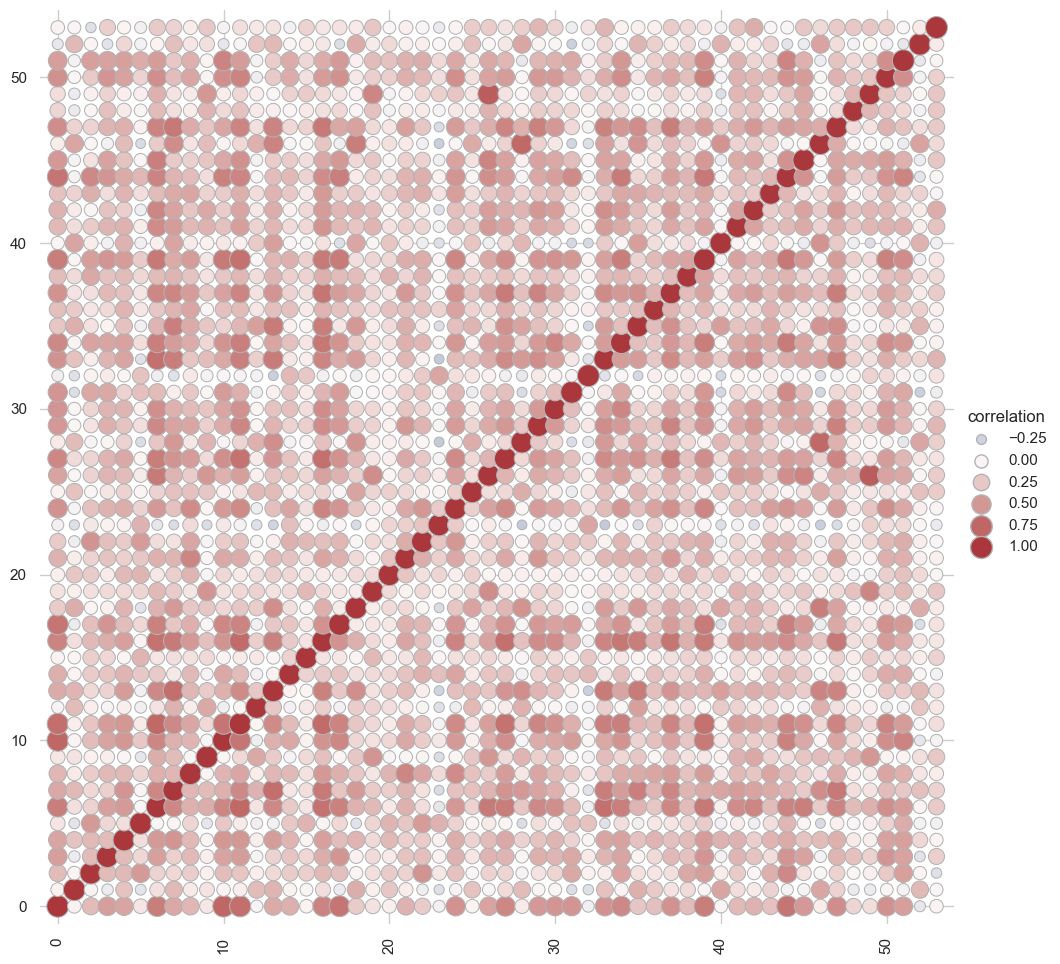

<Figure size 640x480 with 0 Axes>

In [93]:
corr = ds['transactionAmount'].to_dataframe().reset_index().pivot(index='day', columns='asset', values=feature).corr()
corr.index.rename('asset_0', inplace=True)
corr_long = corr.stack().rename('correlation')
g = sns.relplot(
    data=corr_long.reset_index(),
    x='asset', y='asset_0', hue='correlation', size='correlation',
    palette="vlag", hue_norm=(-1, 1), edgecolor=".7",
    height=10, sizes=(50, 250), size_norm=(-.2, .8),
)

# Tweak the figure to finalize
g.set(xlabel="", ylabel="", aspect="equal")
g.despine(left=True, bottom=True)
g.ax.margins(.02)
for label in g.ax.get_xticklabels():
    label.set_rotation(90)
for artist in g.legend.legendHandles:
    artist.set_edgecolor(".7")
plt.figure(f'Correlation for transactionAmount')